# NHL 24 HUT World Championship, a Post Mortem Analysis
### What went wrong

NHL 24 is a game produced by EA Sports. HUT stands for "Hockey Ultimate Team" where you create your own version of an allstar team over time. This was a widely publicized event and required signing up several weeks in advance. I went into it without many expectations. I don't consider my skill level poor but I know I am not good. These games were long format and an entire game would take about half an hour, using Stanley Cup rules (5v5 OT, no shootout). I played 9 games in the HUT World Championship and I lost most games by being outscored nearly 6:1. This was a very bad showing on my part.

My motivation is to analyze the data in an attempt to understand what went wrong and identify strategies for improving my game skill. In general, this is how I approach problem solving. I had some data going into this experiment that might help me discern tangiable stategies from improvement. I don't consider myself a data scientist anymore-- I am just a dude who got put to shame on xbox and I want to be better next time around. I normally don't use Jupyter, I am kind of set in my ways, but this is a nice way to tell a story using data-- my goal here is to walk through the analysis. I think this is what solving hard issues in 2024 is going to need to look like more regularly - a common sense blend of a little data science, data storytelling, creative proble framing, and business analysis. 

This entire analysis is repeatable and will update with very little effort. I can also pull in all kinds of content.

*When I was just starting my career in Data, I spent a lot of time browsing the content at FiveThirtyEight. Nate Silver is a legend and I believe that taking an abstract issue like getting lit up in video games can have real world learnings if you distill them right.*

##### Import Packages 
This is how you import packages in Python. Most of these are preloaded in the anaconda distribution, which I have helped dozens of people get familar with over my career.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pandasql import sqldf
from IPython.display import display, HTML, Image
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices


def sqlQuery(string):
    '''
    Parameters
    ----------
    string : String of SQL query using dataframes in document
    Returns
    -------
    SQL Query
    '''
    return sqldf(string, globals())

##### Get Data
I have three types of game data I am going to use. I have data from the world championship games, I have data from my season leading up (shorter format games), and I have some shot data from 2 particually bad games that I transcribed for this purpose.

In [2]:
#get data 
net_pic = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\CleanNet.PNG"
path = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\NHL Scores 01162024-2.xlsx"
overload_pic = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\Overload Strat Pic.PNG"
breakout = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\up-hockey-breakout.jpg"
pp_strat = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\PP Strat.PNG"
shot_net = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\ShotNet.PNG"
offensive_zone = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\Shooting Areas.PNG"
offensive_zone_blank = r"C:\Users\calholt\Documents\Callaway\NHL24\Data\Offensive Zone Blank.PNG"

shots = pd.read_excel(path, sheet_name = 'Shot Raw Data')
regular = pd.read_excel(path, sheet_name = 'Data', header = 5)
wc = pd.read_excel(path, sheet_name = 'WC Data', header = 5)
players = pd.read_excel(path, sheet_name = 'Team Info', header = 5)
shot_area = pd.read_excel(path, sheet_name = 'Shooting Areas')

#cut out bad data 
wc.drop(columns = ['Unnamed: 17','SMA'], inplace = True)
regular.drop(columns = ['Unnamed: 12','SMA'], inplace = True)
shots.fillna(0, inplace = True)

## Meet the Team
Let's meet the team. EA is very guilty of running a pay to play (*play well*) strategy in their games. You can basically pay money for better players. I haven't done this and so my team was certianly below average in terms of skill. Nonetheless, it is still many of my favorite players and if this were a real team, I think they would be an absolute wagon with tons of fan appeal. 

In [3]:
# using SQL because its easier and faster for me. I don't like pandas groupby as great as pandas is. 
team = sqlQuery("""
            select 
                Player
                ,Line
                ,Position
                ,Shoots
                ,Style
                ,min(Ovr) as Skill
            from players
            group by line, Player, Style
            order by line asc
            """)
team

Player Line       Position Shoots                 Style  Skill
0         Quinn Hughes   D1  Right Defense   Left  Offensive Defenseman     85
1           Seth Jones   D1   Left Defense  Right    Two Way Defenseman     89
2          Brock Faber   D2   Left Defense  Right    Two Way Defenseman     86
3         John Carlson   D2  Right Defense  Right    Two Way Defenseman     83
4             Adam Fox   D3   Left Defense  Right  Offensive Defenseman     84
5         Drew Doughty   D3  Right Defense  Right    Two Way Defenseman     83
6        Alex Ovechkin   F1      Left Wing  Right                Sniper     85
7        Connor Bedard   F1         Center  Right                Sniper     86
8           The Nasher   F1     Right Wing   Left             Playmaker     87
9       David Pastrnak   F2      Left Wing  Right                Sniper     86
10     Nikita Kucherov   F2     Right Wing   Left                Sniper     92
11       Trevor Zegras   F2         Center   Left             Playmaker     85
12        Dany Heatley   F3     Right Wing   Left                Sniper     80
13        Mitch Marner   F3         Center  Right             Playmaker     77
14       Patrick Laine   F3      Left Wing  Right                Sniper     84
15       Claude Ciroux   F4         Center  Right             Playmaker     81
16         Taylor Hall   F4      Left Wing   Left             Playmaker     82
17    William Nylander   F4      Left Wing  Right             Playmaker     83
18  Andrei Vasilevskiy   G1         Goalie   Left                Hybrid     84
19    Jacob Markstrorm   G2         Goalie   Left                Hybrid     84

There isn't really one scorer that I count on more than others. Ovechkin has the most points followed by Nasher and Pasta. My D men also rack up many points. My team is all Playmakers and Snipers and my defense is offensively biased. 

My team is all gas and no breaks. My only player in the 90's range is a new addition. Most of my opponents had multiple players 90+ skill. Overall, my teams average is an 83 skill.

## Our Strategy
Like I said my team is really set up to be Snipers, meaning we are going to try and put accurate shots on net to score. My team is set up to look for a shot on the weak side (where the defenses attention is shifted). The best player in the world (Alex Ovechkin) is about to surpass Wayne Gretky for goal scoring, a milestone thought improssible to surpass, from standing at the top of the left circle and hammering shots when the play is on the right side of the ice and no one is looking at him. This bias towards shooting is evident in both my full strength and power play approach.

In [4]:
iframe_code = """
<iframe src="https://giphy.com/embed/3iyVPUiICrqJtmv00I" width="480" height="270" frameBorder="0" class="giphy-embed" allowFullScreen></iframe>
<p><a href="https://giphy.com/gifs/nhl-caps-capitals-3iyVPUiICrqJtmv00I">via GIPHY</a></p>
"""

# Displaying the HTML content in the Jupyter Notebook
display(HTML(iframe_code))


#### Even Strength

My best two lines run an overload strategy. 
The overload strategy in even-strength situations is about creating advantages by strategically positioning players and exploiting defensive weaknesses. It requires effective communication, player movement, and an understanding of the opponent's defensive structure. Coaches may implement specific systems or plays to encourage an overload in certain area of the ice.

My bottom two lines Crash the Net, meaning they take the puck hard to the net to see what happens. They end up shooting a lot though also just like lines 1 and 2. This actually could help them with goal production and lucky, dirty goals.

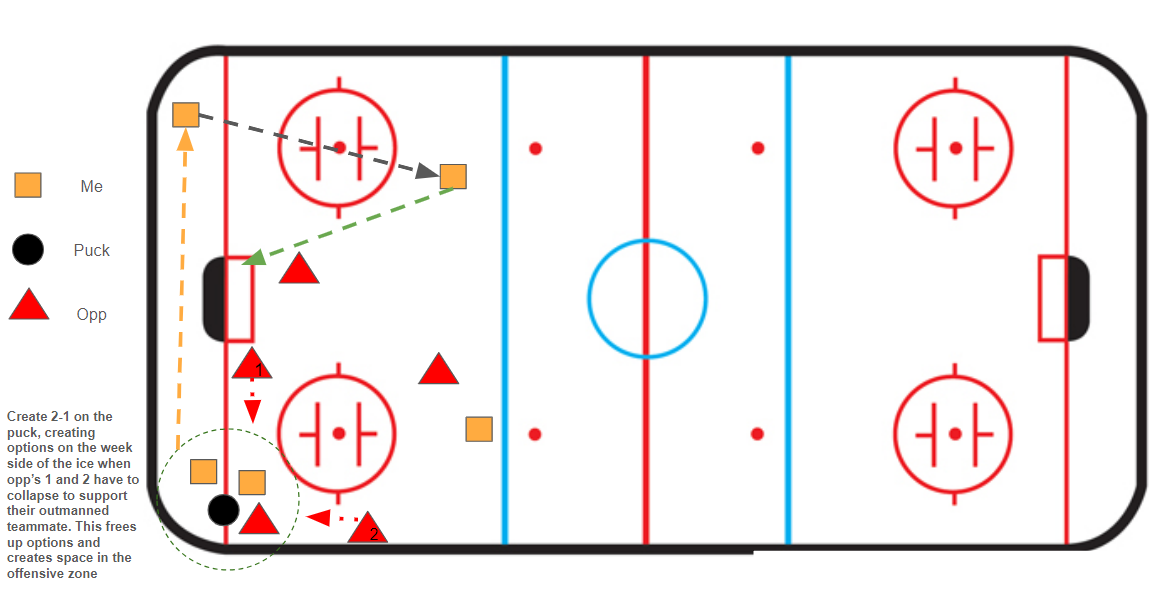

In [5]:
display(Image(filename=overload_pic))

#### Breakout

When I am stuck in my D zone, I try to get out out the zone by having the center swing high and catch a long breakout pass or the weak side wing go even higher. This is pretty standard 14 year old level hockey stuff but works for me. This is because my puck possession game is weak and the less I can have the puck skating though the neutral zone, the better.

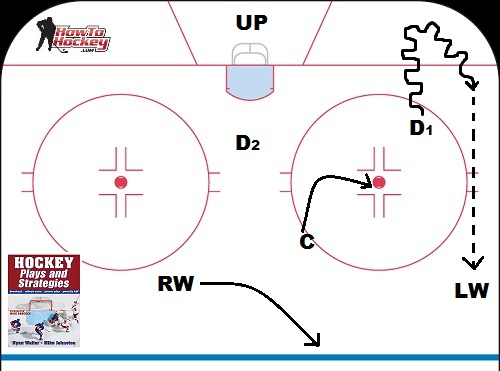

In [6]:
display(Image(filename=breakout))

#### Powerplay

I use an Umbrella strategy in the power play. Because of all of the weapons I have at my disposal, I don't need to favor a particular side of the ice, but ideally we want a pass to shift the play and open a scoring lane off to the weak side. My second power play unit is very similar in makeup and approach.

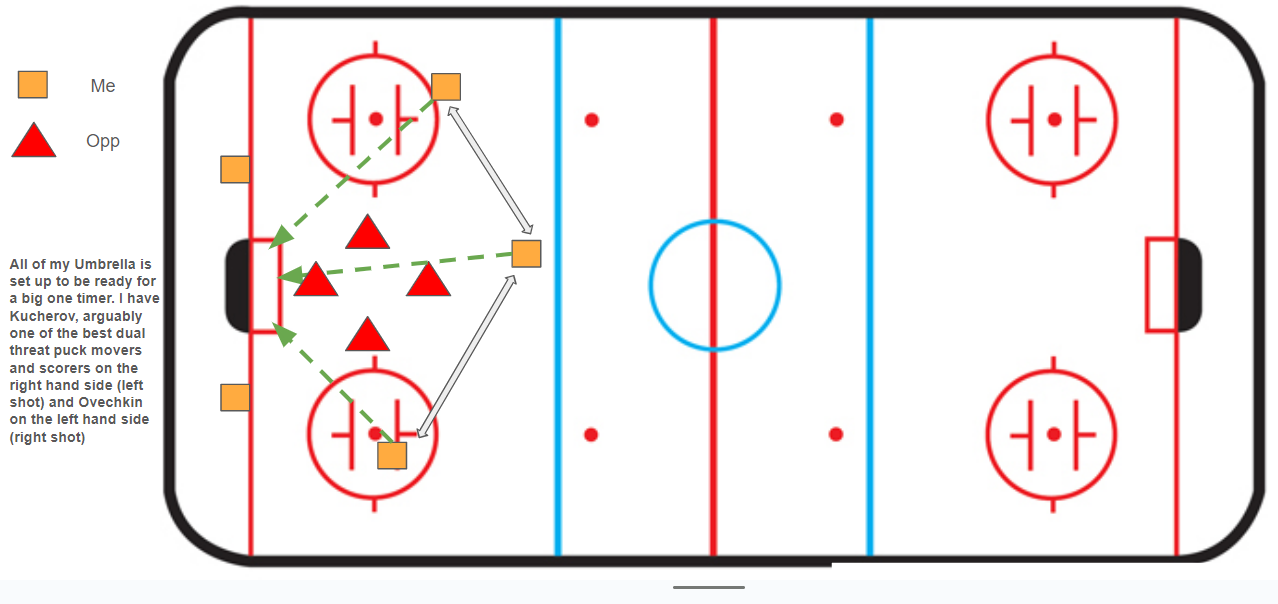

In [7]:
display(Image(filename=pp_strat))

## Momentum Going Into WC
Let's look at how I was doing going into the tournament. These data come from games that were in a 2 minute period format, so they were quick games. Since starting my data tracking, my record is 20-24-4.

In [8]:
pd.DataFrame(regular.Outcome.value_counts())

count
Outcome       
W           21
L           20
OTL          6
SOL          5
OTW          2

#### Scoring and Shooting

Let's look at how I was scoring over time

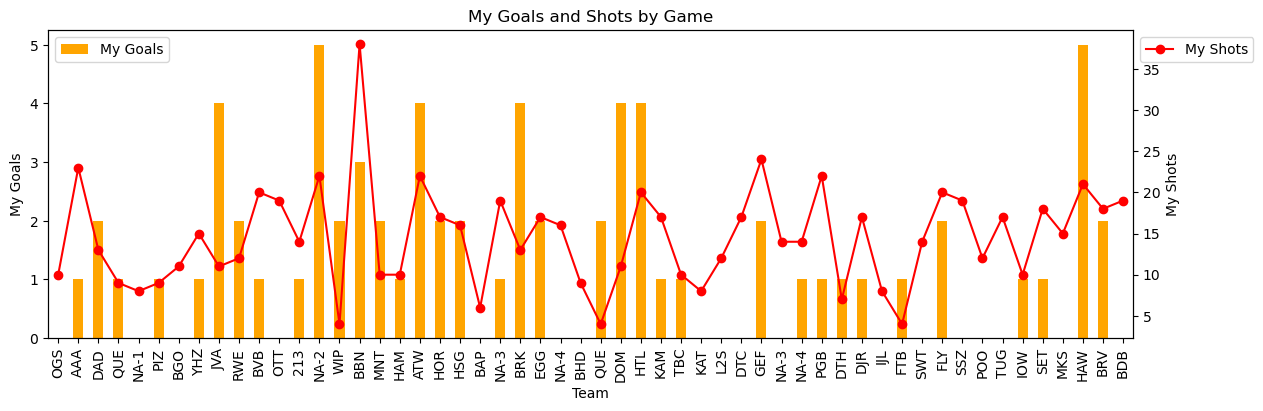

In [9]:
ax1 = regular.plot(kind = 'bar', y = 'MNA', x = 'Team', figsize = (14,4), color = 'orange', label = 'My Goals')
ax2 = ax1.twinx()
regular.plot(kind='line', y='MNA Shots', ax=ax2, color='red', marker='o', label='My Shots')
ax1.set_ylabel('My Goals')
ax2.set_ylabel('My Shots')
plt.title('My Goals and Shots by Game')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Lets think a little harder about this. What does average look like in this situation with shots and goals? A regression would show the influence shots have on top of goals for every incremental shot (beta coeff), beyond the starting point (y int)

In [10]:
# Specify the formula using the Q() function for the column with spaces
formula = 'MNA ~ Q("MNA Shots")'
# Create matrices for the model
y, X = dmatrices(formula, data=regular, return_type='dataframe')
# Fit the linear regression model
model = sm.OLS(y, X).fit()
formatted_formula = f"{model.model.endog_names} = {model.params[0]:.2f} + {model.params[1]:.2f} * {model.model.exog_names[1]}"
print("Regression Formula:")
print(formatted_formula)
# Display the regression results
print(model.summary())

Regression Formula:
MNA = 0.33 + 0.07 * Q("MNA Shots")
                            OLS Regression Results                            
Dep. Variable:                    MNA   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     5.259
Date:                Tue, 16 Jan 2024   Prob (F-statistic):             0.0259
Time:                        19:49:00   Log-Likelihood:                -91.718
No. Observations:                  54   AIC:                             187.4
Df Residuals:                      52   BIC:                             191.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

Wow this isn't good. Basically what this means is that on a average my team will score half a goal and for every additional 16 shots I will score 1 goal beyond that. That is evident when you take the following formula:

In [11]:
print(formatted_formula)

MNA = 0.33 + 0.07 * Q("MNA Shots")


and do the following:

In [12]:
beta_coeff = .0625

print(int(100/(beta_coeff * 100)), " Shots needed per goal")

16  Shots needed per goal


Ok so thats pretty bad which explains the following chart of my opponent and me:

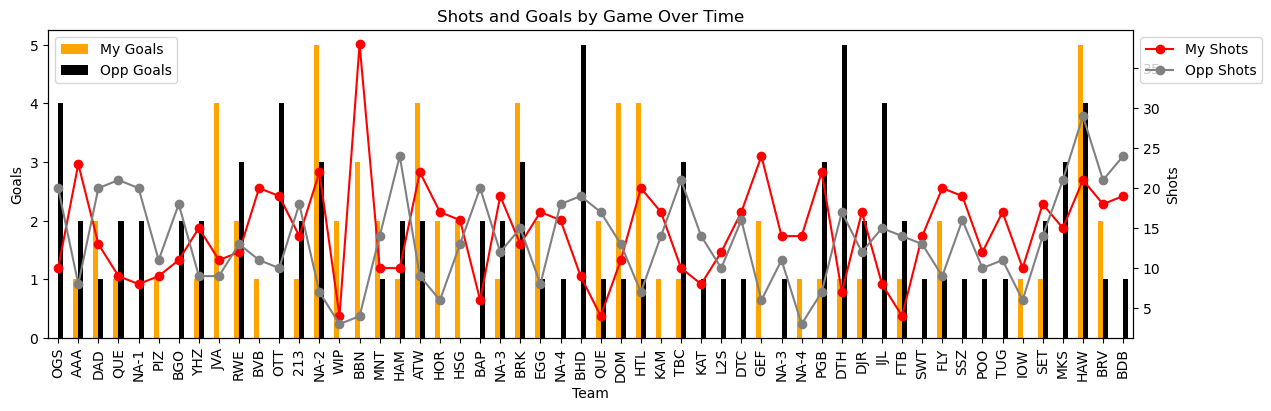

In [13]:
ax1 = regular.plot(kind = 'bar', y = ['MNA','Opp'], x = 'Team', figsize = (14,4), color = ['orange','black'], label = ['My Goals','Opp Goals'])
ax2 = ax1.twinx()
# Plot the second variable on the secondary y-axis
regular.plot(kind='line', y=['MNA Shots', 'Opp Shots'], ax=ax2, color=['red', 'grey'], marker='o', label=['My Shots', 'Opp Shots'])
# Set labels and legend
ax1.set_ylabel('Goals')
ax2.set_ylabel('Shots')
plt.title('Shots and Goals by Game Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

## Other Key Insights

#### Shooting Accuracy and Shot Placement

This is super sweet that I was able to do this. This really resonates with my general perspective on where we sit today in a business landscape. Valuable data is out there but it is hard to get. To get shooting data, I took pictures from 2 games during the WC. I then broke the net up into 36 zones and counted shots and goals. This looked like this:

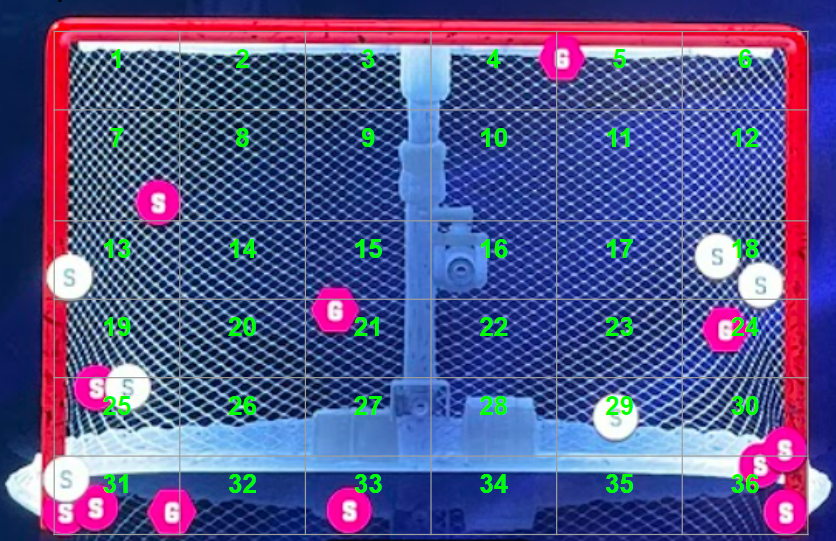

In [14]:
display(Image(filename=shot_net))

This was really annoying to do and I am sure AI could be applied here. I bet I could figure this out with a little more time spent.

In [22]:
def getShotMap(dataframe, col, scheme):
    grid_values = dataframe[col].values.reshape((6, 6))
    background_img = plt.imread(net_pic)
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figsize if needed
    extent_matrix = (0, 6, 0, 6)
    extent_image = (0, 6, 0, 6)  # Match the matrix size
    #norm = plt.Normalize(vmin=0, vmax=np.max(dataframe[col]))
    # Plot the 6x6 matrix first
    cmap = plt.get_cmap(scheme)
    im = ax.imshow(grid_values, cmap=scheme, interpolation='nearest', vmin=0, vmax=np.max(dataframe[col]), extent=extent_matrix)
    # Add text annotations for each cell with floating-point labels
    for i in range(6):
        for j in range(6):
            ax.text(j+.5, 5.5 - i, f'{grid_values[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)
    # Plot the background image on top of the matrix with some transparency
    ax.imshow(background_img, extent=extent_image, aspect='auto', zorder=1, alpha=0.5)
    # Add a colorbar for reference
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)
    # Hide axes for better visibility
    ax.axis('off')
    # Set the title
    ax.set_title(col)
    # Show the plot
    return plt.show()

Lets look at some hard metrics:

In [23]:
# shooting
agg_shots = shots.drop(columns = ['Photo']).groupby('Location').sum()
agg_shots.reset_index(inplace = True)
agg_shots['Shots'] = agg_shots['Opp Shots'] + agg_shots['MNA Shots']
agg_shots['Total Goals'] = agg_shots['Opp G'] + agg_shots['MNA G']
agg_shots['Total Shots'] = agg_shots['Shots'] + agg_shots['Total Goals']
agg_shots['Shooting PCT'] = agg_shots['Total Goals']/ agg_shots['Total Shots']
agg_shots['Shot Dist'] = agg_shots['Total Shots'] / agg_shots['Total Shots'].sum()
agg_shots['Goal Dist'] = agg_shots['Total Goals'] / agg_shots['Total Goals'].sum()

Lets think about this for a second. We have the percent chance that a puck goes into the net in for each zone. We also have the shot distibution, which witholding the ability to aim, is the distribution of where shots will go on net. If we combine these two things, we will be able to get a "Goal Yeild" (which I just like the name of) for each location on the net. We can then assume that any 1 puck thrown on net will be subject to the combine goal yeild of all 36 zones.

In [24]:
agg_shots['Goal Yeild/1000'] = (agg_shots['Shot Dist'] *agg_shots['Shooting PCT'])*100
agg_shots.fillna(0, inplace = True)

We basically know that for every random 1000 shots we will gain the sum of the goal yeild:

In [39]:
print(round(agg_shots['Goal Yeild/1000'].sum(),2), 'Per 1000 Shots')
print(round(1000/agg_shots['Goal Yeild/1000'].sum(),2), 'Shots per one goal')
print('Every one shot will get me',1/round(1000/agg_shots['Goal Yeild/1000'].sum(),2),'goals on average over time')

21.43 Per 1000 Shots
46.67 Shots per one goal
Every one shot will get me 0.021427040925648167 goals on average over time


This is bad. Lets look at what the shots look like on net. Note that I am still figuring out how to get the coloring right but this could be corrected in excel pretty quick

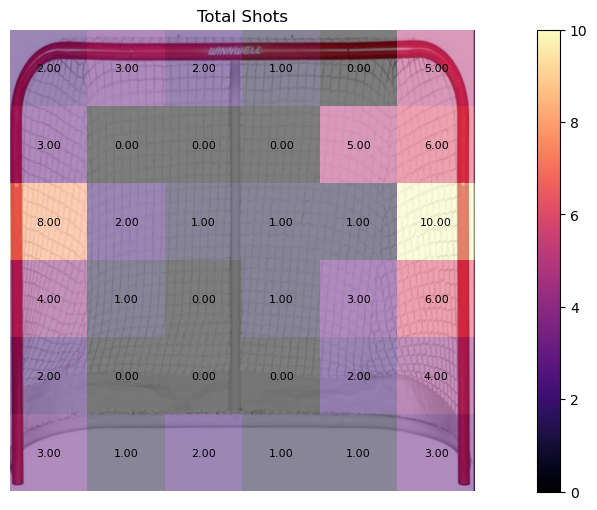

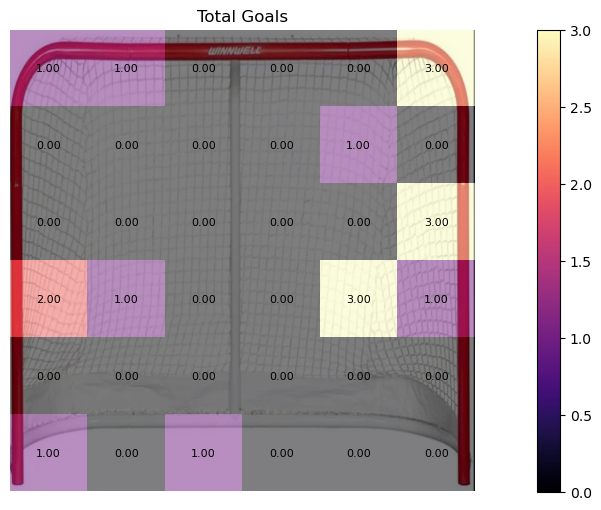

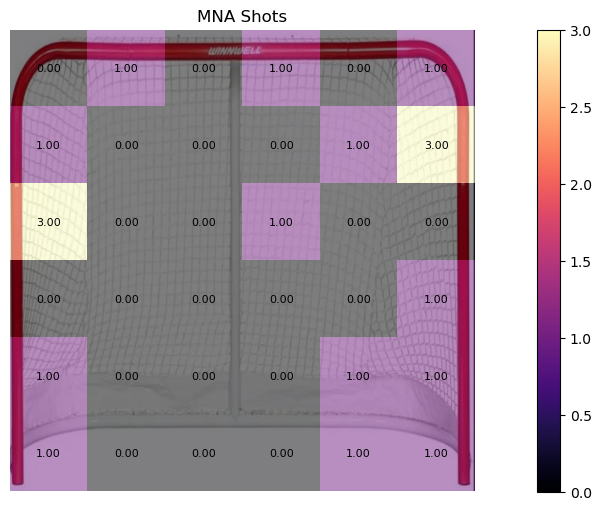

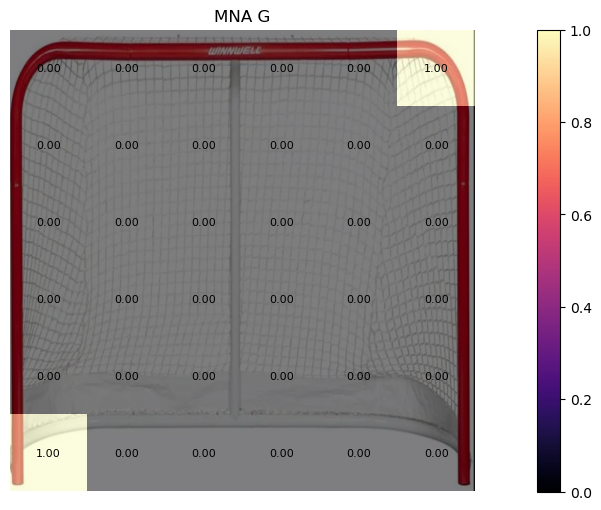

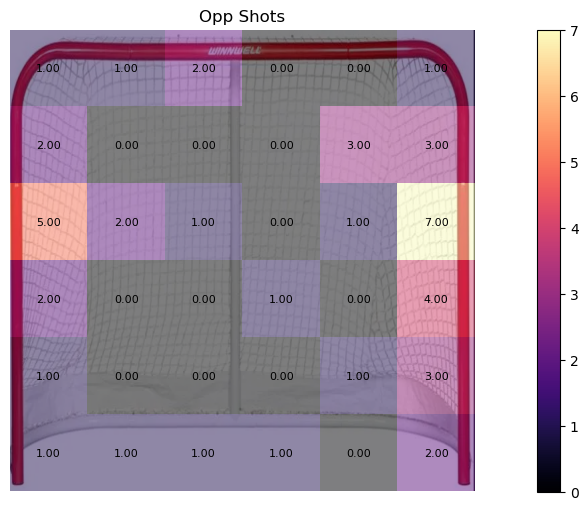

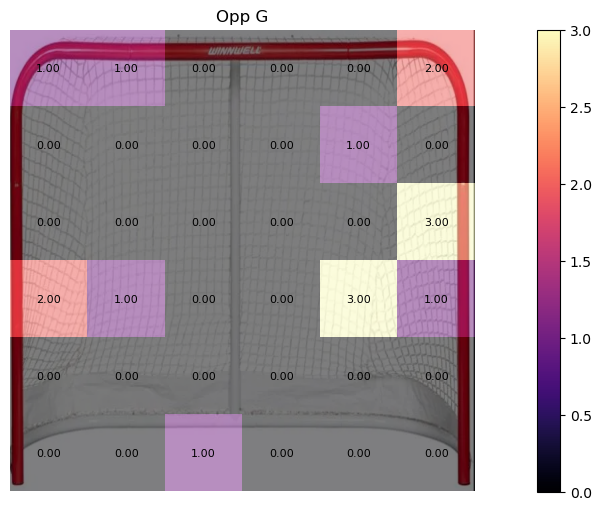

In [26]:
for value in ['Total Shots','Total Goals','MNA Shots', 'MNA G', 'Opp Shots', 'Opp G']:
    getShotMap(agg_shots, value, 'magma') #bilinear

Let's look at some invented KPIs

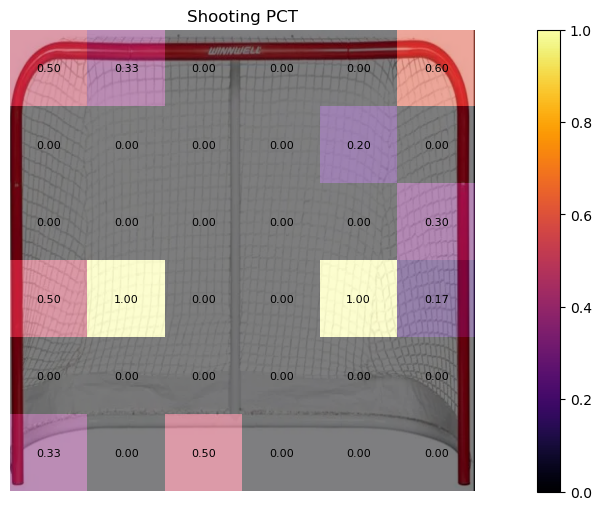

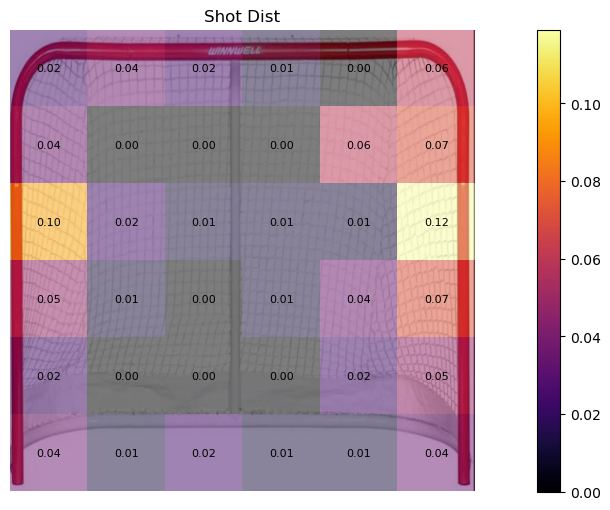

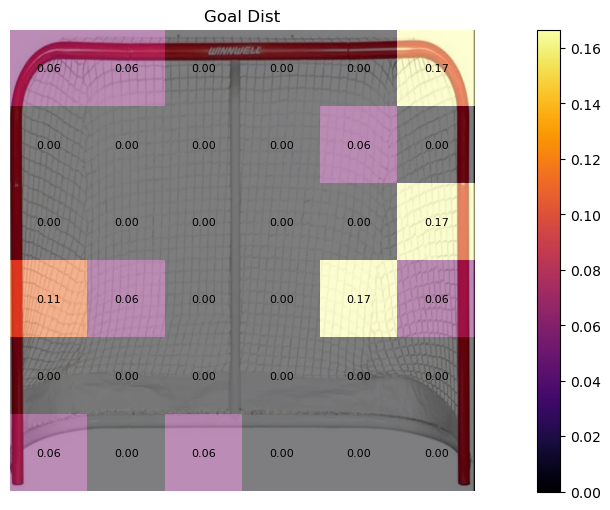

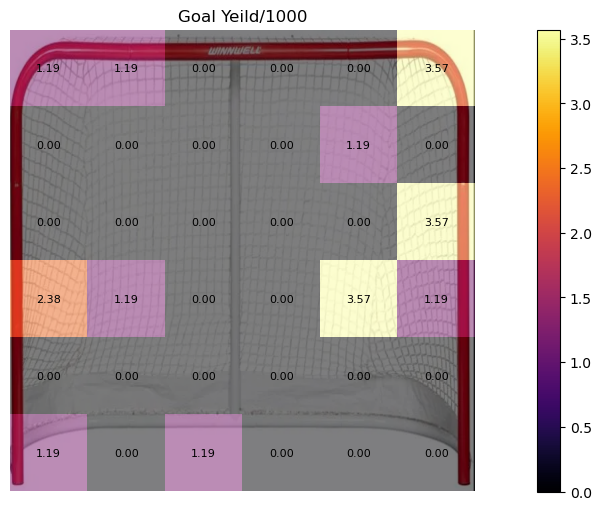

In [28]:
for value in ['Shooting PCT','Shot Dist', 'Goal Dist', 'Goal Yeild/1000']:
    getShotMap(agg_shots, value, 'inferno')

Ok so what all of this tells me is that for both my opponents and I, the best places to try and put the puck are mid blocker side, mid glove side, low glove side. I never would have thought that. So now the question is how do we impliment a plan to get those shots on net within my existing strategy?

#### Shooting Areas

My approach to discerning best areas on the ice to take shots also follows a grid. By breaking the offense zone into 18 parts we are able to have a good amount and specificity when referring to locations

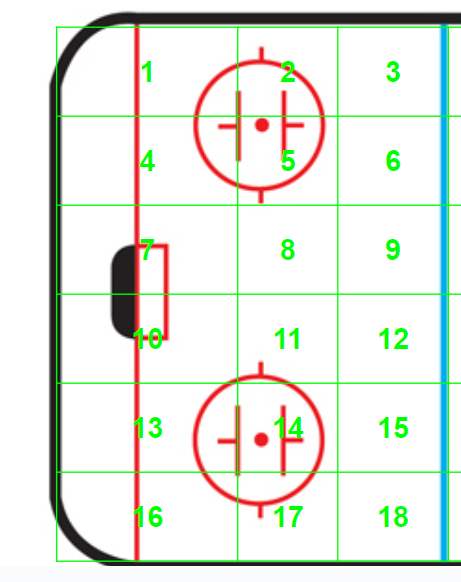

In [30]:
display(Image(filename=offensive_zone))

I then took some photos from a few games and transcribed that into a google doc to end up with some workable data

In [31]:
# shooting
agg_shots_areas = shot_area.drop(columns = ['Team']).groupby('Location').sum()
agg_shots_areas.fillna(0,inplace = True)

agg_shots_areas['Shots'] = agg_shots_areas['Opp Shots'] + agg_shots_areas['MNA Shots']
agg_shots_areas['Total Goals'] = agg_shots_areas['Opp G'] + agg_shots_areas['MNA G']
agg_shots_areas['Total Shots'] = agg_shots_areas['Shots'] + agg_shots_areas['Total Goals']
agg_shots_areas['Shooting PCT'] = agg_shots_areas['Total Goals']/ agg_shots_areas['Total Shots']
agg_shots_areas['Shot Dist'] = agg_shots_areas['Total Shots'] / agg_shots_areas['Total Shots'].sum()
agg_shots_areas['Goal Dist'] = agg_shots_areas['Total Goals'] / agg_shots_areas['Total Goals'].sum()
agg_shots_areas.fillna(0,inplace = True)
agg_shots_areas.reset_index(inplace = True)

Renumber the zones so that flipping the visual is easier and I won't need to rotate text later. I am not comfortable changing the raw data in its actual document because I know its right, just inconvient. This is why I like python - I worked really hard to collect this data and despite having messed up slightly, I will be able to quickly fix and be able to see the process I impliment to fix the small issue. This is just a normal data hicup. 

In [32]:
def newZones(value):
    if value == 16:
        return 1
    elif value == 13:
        return 2
    elif value == 10:
        return 3
    elif value == 7: 
        return 4
    elif value == 4:
        return 5
    elif value == 1:
        return 6
    elif value == 17:
        return 7
    elif value == 14:
        return 8
    elif value == 11:
        return 9
    elif value == 8:
        return 20
    elif value == 5:
        return 11
    elif value == 2:
        return 12
    elif value == 18:
        return 13
    elif value == 15:
        return 14
    elif value == 12:
        return 15
    elif value == 9:
        return 16
    elif value == 6:
        return 17
    elif value == 3:
        return 18
    else:
        pass

agg_shots_areas['new_zone'] = [newZones(x) for x in agg_shots_areas.Location]

## CH to Do: Explain why I needed to transform the zones

In [33]:
agg_shots_areas[['Location','new_zone']].reset_index()


index  Location  new_zone
0       0         1         6
1       1         2        12
2       2         3        18
3       3         4         5
4       4         5        11
5       5         6        17
6       6         7         4
7       7         8        20
8       8         9        16
9       9        10         3
10     10        11         9
11     11        12        15
12     12        13         2
13     13        14         8
14     14        15        14
15     15        16         1
16     16        17         7
17     17        18        13

In [51]:
def getZoneMap(dataframe, col, scheme, image_path, style):
    grid_values = dataframe[col].values.reshape((3, 6))
    background_img = plt.imread(image_path)
    # Create subplots with 33% vertical shrinkage
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize if needed
    # Set the extent to match the matrix (adjust vertical extent as needed)
    extent_matrix = (0, 6, 0, 3)
    extent_image = (0, 6, 0, 3)  # Match the matrix size
    cmap = plt.get_cmap(scheme)
    im = ax.imshow(grid_values, cmap=scheme, interpolation= style, vmin=0, vmax=np.max(dataframe[col]), extent=extent_matrix)
    # Add text annotations for each cell with floating-point labels
    for i in range(3):
        for j in range(6):
            ax.text(j + 0.5, 2.5 - i, f'{grid_values[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)
    ax.imshow(background_img, extent=extent_image, aspect='auto', zorder=1, alpha=0.5)
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)
    # Hide axes for better visibility
    ax.axis('off')
    ax.set_title(col)
    return plt.show()


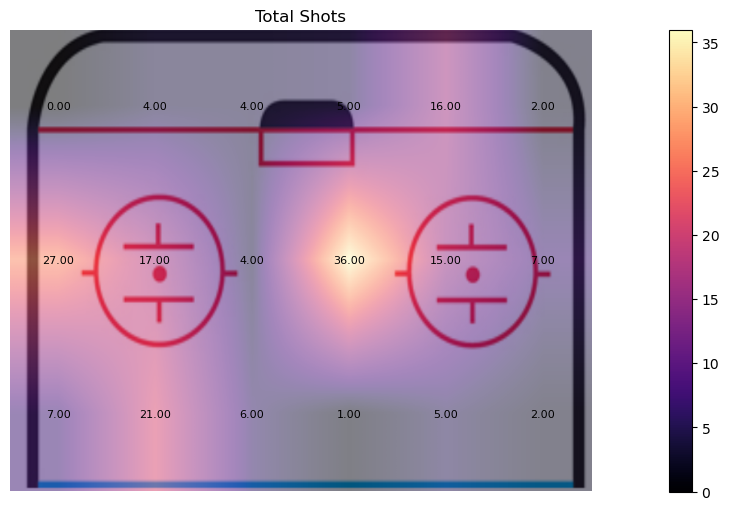

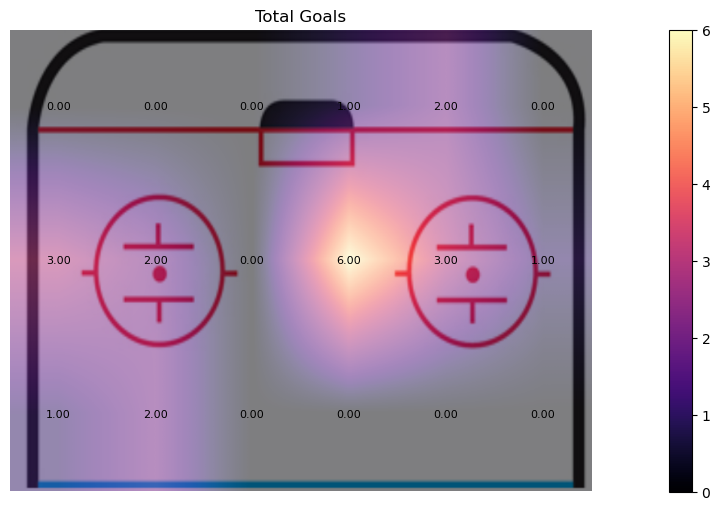

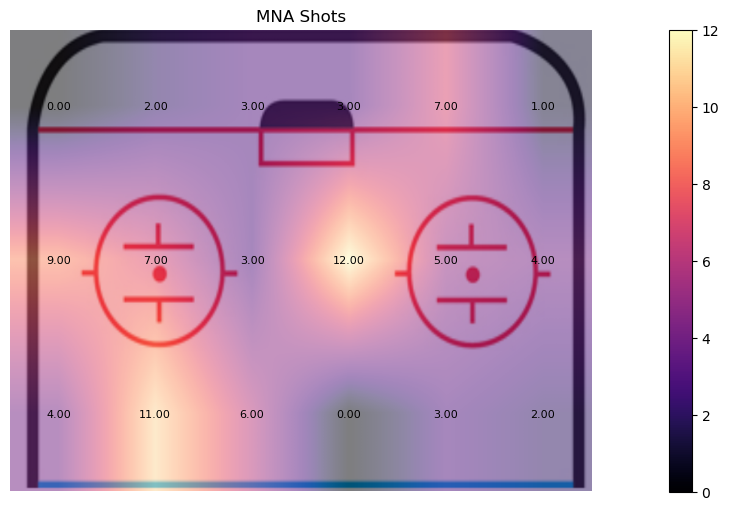

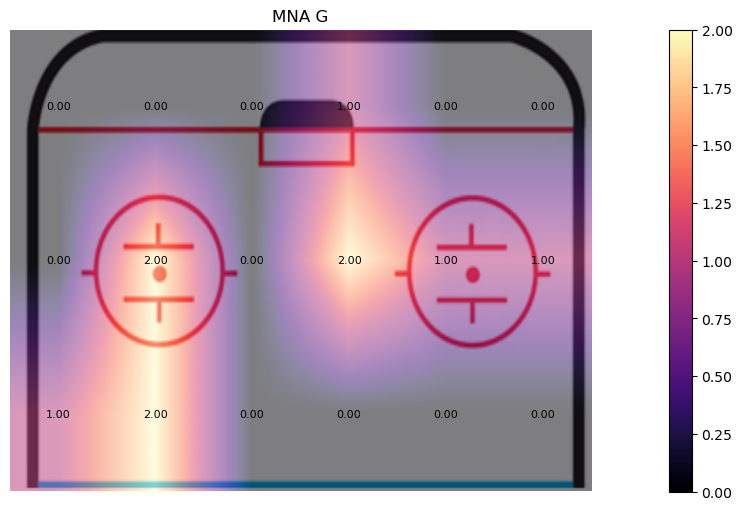

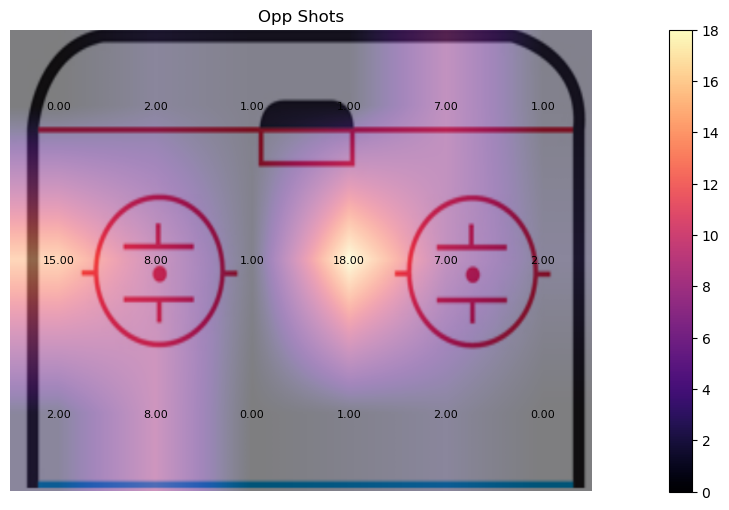

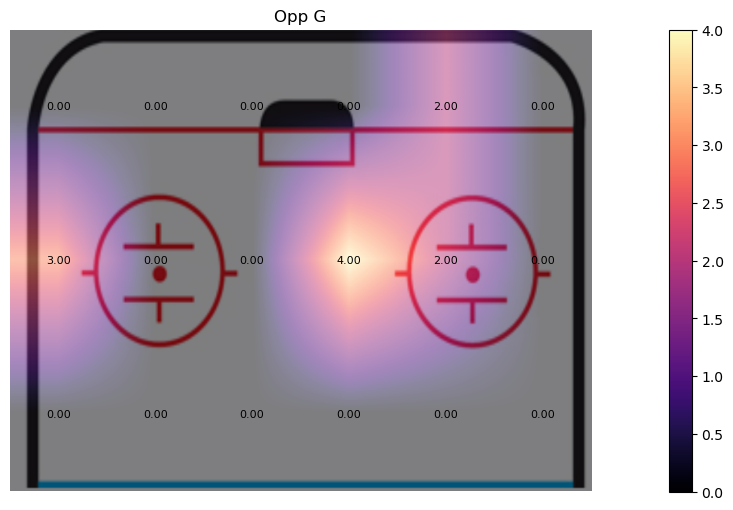

In [52]:
for value in ['Total Shots','Total Goals','MNA Shots', 'MNA G', 'Opp Shots', 'Opp G']:
    getZoneMap(agg_shots_areas, value, 'magma',offensive_zone_blank, 'bilinear') #bilinear

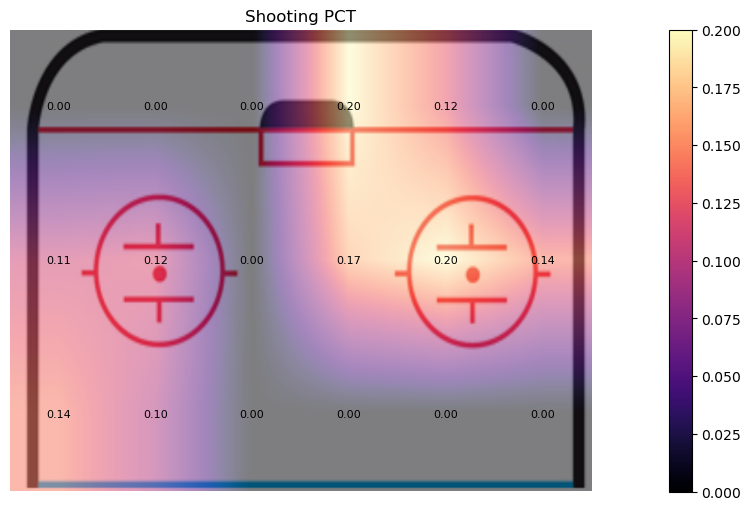

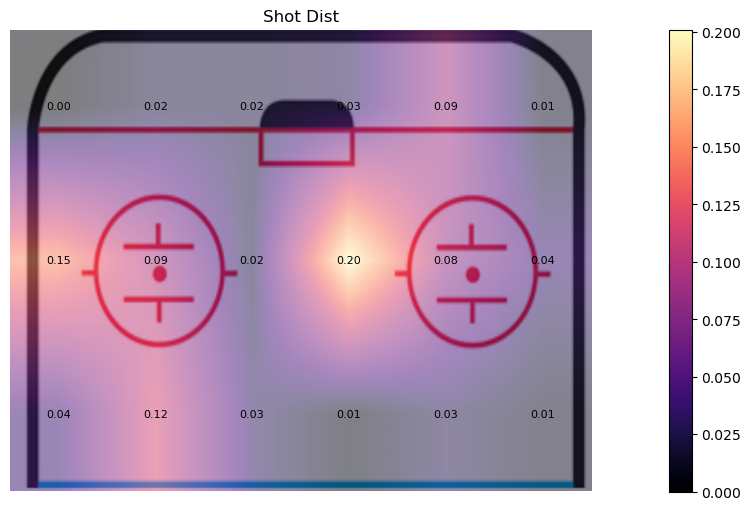

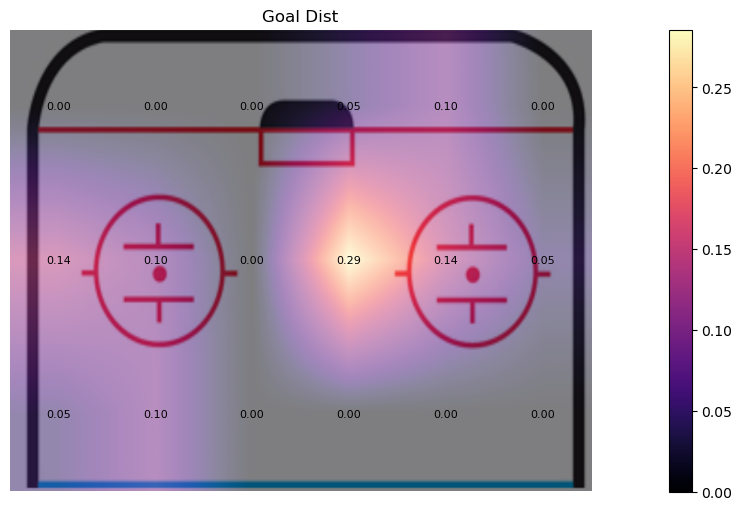

KeyError: 'Goal Yeild/1000'

In [53]:
for value in ['Shooting PCT','Shot Dist', 'Goal Dist', 'Goal Yeild/1000']:
    getZoneMap(agg_shots_areas, value, 'magma',offensive_zone_blank, 'bilinear') #bilinear
